In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# Load the three CSV files\
df_data = pd.read_csv('pandas/df_data.csv', low_memory=False)
df_filtered = pd.read_csv('pandas/df_filtered.csv')
agg_df = pd.read_csv('pandas/agg_df_cluster.csv')
fish_df = pd.read_csv('pandas/fish_df_cluster.csv')

In [33]:
# Specify cluster to analyze
cluster_num = 4

# Filter data for this cluster
cluster_data = agg_df[agg_df['cluster'] == cluster_num]
cluster_fish_data = df_filtered[df_filtered['barcode'].isin(cluster_data['barcode'])]

# Environmental variables summary (median)
env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
env_summary = cluster_data[env_vars].median()

# Categorical variables summary (mode)
cat_vars = ['mode_substrt']
cat_summary = cluster_data[cat_vars].mode().iloc[0]

# Binary variables summary (proportion present)
binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
binary_summary = cluster_data[binary_vars].mean()

# Fish species counts
fish_in_cluster = fish_df[agg_df['cluster'] == cluster_num].drop(columns=['cluster'])
species_counts = fish_in_cluster.sum().sort_values(ascending=False)
species_counts = species_counts[species_counts > 0]

cluster_barcodes = agg_df[agg_df['cluster'] == cluster_num]['barcode']

# Total individuals caught
fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
#fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

# Number of samples where present
fish_in_cluster = fish_df[agg_df['cluster'] == cluster_num].drop(columns=['cluster'])
fish_occurrence = fish_in_cluster.sum()

# Combine
species_summary = pd.DataFrame({
    'total_caught': fish_abundance,
    'samples': fish_occurrence,
    'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
}).fillna(0).astype({'total_caught': int, 'samples': int})
species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)


# Print summary
print(f"=== CLUSTER {cluster_num} SUMMARY ===")
print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
print("\n--- Environmental Variables (Median) ---")
print(env_summary)
print("\n--- Categorical Variables (Mode) ---")
print(cat_summary)
print("\n--- Binary Variables (Proportion Present) ---")
print(binary_summary)
print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
print(species_summary)

=== CLUSTER 4 SUMMARY ===

Total samples (identified by barcode): 5

--- Environmental Variables (Median) ---
median_temp        12.00
median_depth        0.90
median_current      0.08
median_esveg92      1.00
median_cond       385.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    2.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.0
riprap_present     0.0
inout_present      0.0
flooded_present    0.0
dtype: float64

--- Fish Species (Count of 5 samples) ---
      total_caught  samples  mean_length
WLYE             7        5        311.6
YWPH             5        3        138.0
FWDM             2        1        324.0
GDRH             1        1        310.0
JYDR             1        1         60.0
LGPH             1        1         80.0
RVRH             1        1        700.0
STSN             2        1         75.0
WTBS             2        1        100.0


In [23]:
# Summarize all clusters at once
for cluster_num in sorted(agg_df['cluster'].unique()):
    cluster_data = agg_df[agg_df['cluster'] == cluster_num]
    cluster_fish_data = df_data[df_data['barcode'].isin(cluster_data['barcode'])]
    
    # Environmental variables summary (median)
    env_vars = ['median_temp', 'median_depth', 'median_current', 'median_esveg92', 'median_cond']
    env_summary = cluster_data[env_vars].median()

    # Categorical variables summary (mode)
    cat_vars = ['mode_substrt']
    cat_summary = cluster_data[cat_vars].mode().iloc[0]

    # Binary variables summary (proportion present)
    binary_vars = ['snag_present', 'riprap_present', 'inout_present', 'flooded_present']
    binary_summary = cluster_data[binary_vars].mean()

    # Fish species counts
    fish_in_cluster = fish_df[agg_df['cluster'] == cluster_num].drop(columns=['cluster'])
    species_counts = fish_in_cluster.sum().sort_values(ascending=False)
    species_counts = species_counts[species_counts > 0]

    cluster_barcodes = agg_df[agg_df['cluster'] == cluster_num]['barcode']

    # Total individuals caught
    fish_abundance = df_filtered[df_filtered['barcode'].isin(cluster_barcodes)].groupby('fishcode').size()
    fish_length = cluster_fish_data.groupby('fishcode')['length'].mean()
    #fish_weight = cluster_fish_data.groupby('fishcode')['weight'].mean()

    # Number of samples where present
    fish_in_cluster = fish_df[agg_df['cluster'] == cluster_num].drop(columns=['cluster'])
    fish_occurrence = fish_in_cluster.sum()

    # Combine
    species_summary = pd.DataFrame({
        'total_caught': fish_abundance,
        'samples': fish_occurrence,
        'mean_length': round(fish_length,1),
#    'mean_weight': fish_weight
    }).fillna(0).astype({'total_caught': int, 'samples': int})
    species_summary = species_summary[species_summary['samples'] > 0].sort_values('samples', ascending=False)


    # Print summary
    print(f"=== CLUSTER {cluster_num} SUMMARY ===")
    print(f"\nTotal samples (identified by barcode): {len(cluster_data)}")
    print("\n--- Environmental Variables (Median) ---")
    print(env_summary)
    print("\n--- Categorical Variables (Mode) ---")
    print(cat_summary)
    print("\n--- Binary Variables (Proportion Present) ---")
    print(binary_summary)
    print(f"\n--- Fish Species (Count of {len(cluster_data)} samples) ---")
    print(species_summary)

=== CLUSTER 1 SUMMARY ===

Total samples (identified by barcode): 3

--- Environmental Variables (Median) ---
median_temp        13.00
median_depth        1.10
median_current      0.25
median_esveg92      0.00
median_cond       435.00
dtype: float64

--- Categorical Variables (Mode) ---
mode_substrt    2.0
Name: 0, dtype: float64

--- Binary Variables (Proportion Present) ---
snag_present       0.0
riprap_present     0.0
inout_present      0.0
flooded_present    0.0
dtype: float64

--- Fish Species (Count of 3 samples) ---
      total_caught  samples  mean_length
LNGR             9        3        562.0
SHRH             3        2        344.0
SNGR            29        2        607.3
GDRH             1        1        480.0
MNEY             2        1        152.0
SMBF             1        1        403.0
=== CLUSTER 2 SUMMARY ===

Total samples (identified by barcode): 1

--- Environmental Variables (Median) ---
median_temp         6.10
median_depth        1.20
median_current      0.73

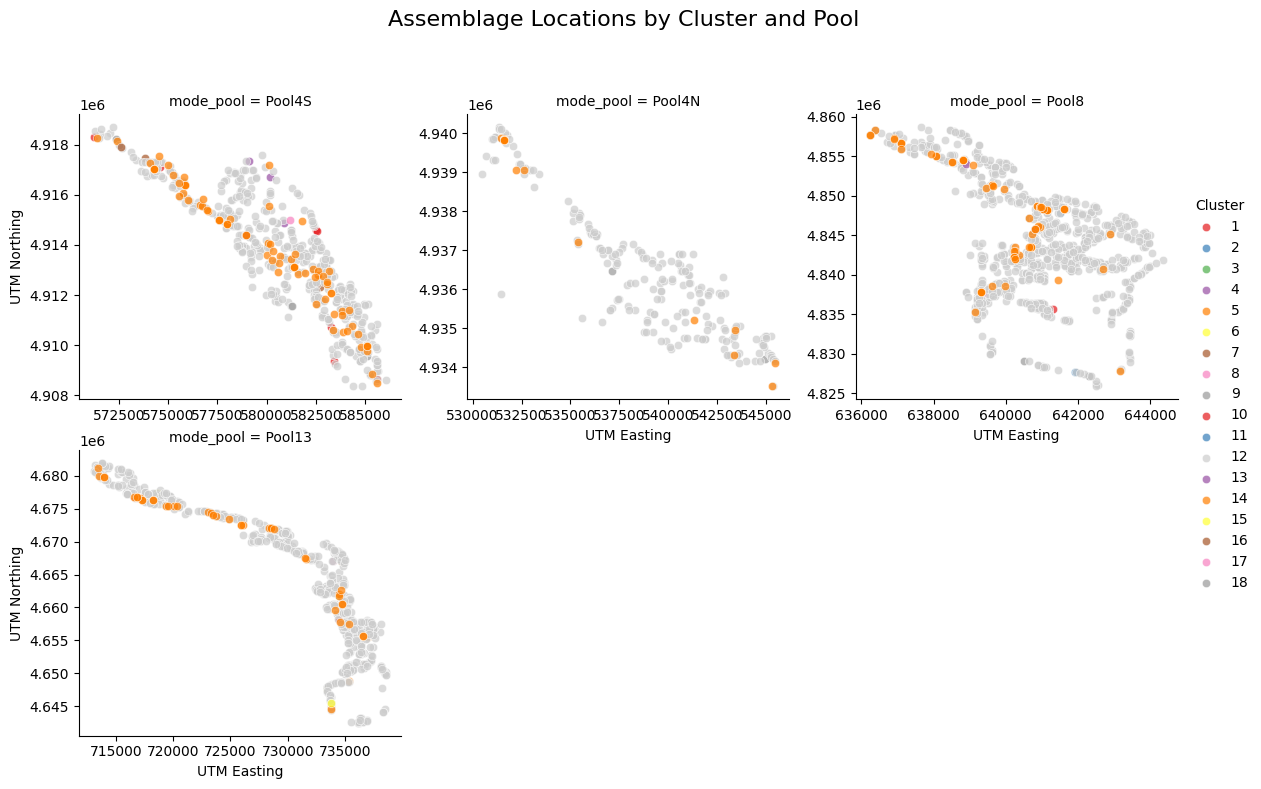

In [34]:
# Find the cluster with the largest count
cluster_sizes = agg_df['cluster'].value_counts()
largest_cluster = agg_df['cluster'].value_counts().idxmax()
unique_clusters = sorted(agg_df['cluster'].unique())
size_map = {c: f"{cluster_sizes[c]} sites" for c in unique_clusters}
palette = sns.color_palette("Set1", n_colors=len(unique_clusters))
light_color = (0.8, 0.8, 0.8)  # RGB for light gray

# Assign palette, but set largest cluster to light gray
color_map = {c: col for c, col in zip(unique_clusters, palette)}
color_map[largest_cluster] = light_color

g = sns.FacetGrid(
    agg_df,
    col="mode_pool",
    hue="cluster",
    palette=color_map,
    col_wrap=3,
    height=4,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="utm_e", y="utm_n", alpha=0.7)
g.add_legend(title="Cluster")
g.set_axis_labels("UTM Easting", "UTM Northing")
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Assemblage Locations by Cluster and Pool", fontsize=16)
plt.show()

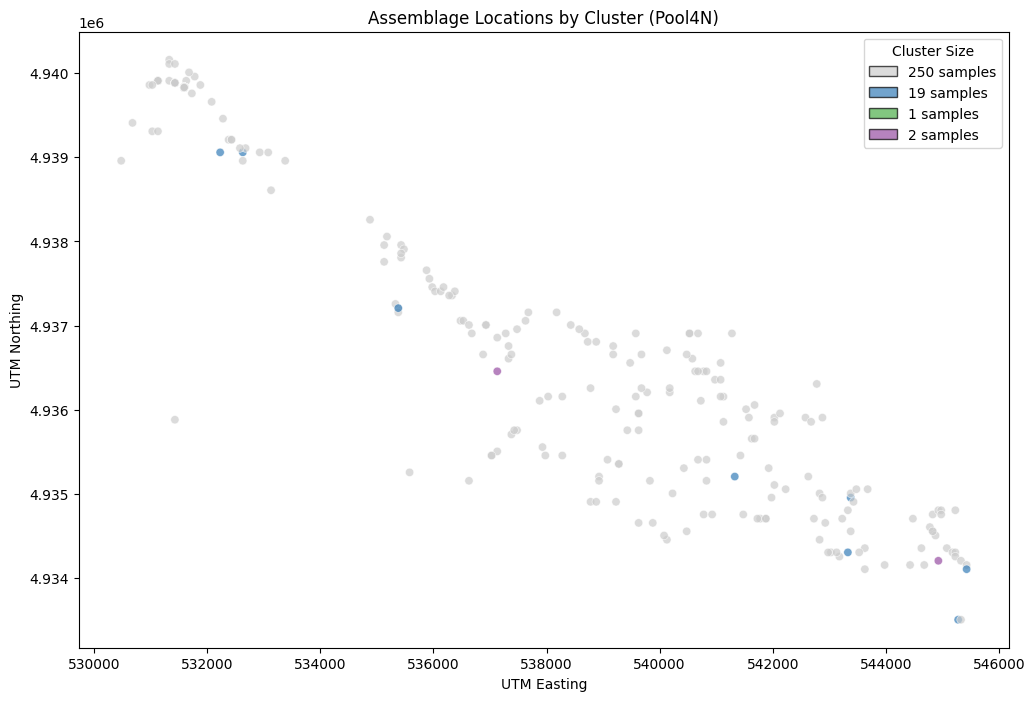

In [35]:
from matplotlib.patches import Patch

# FILTER by pool
pool_filter = 'Pool4N'
available_pools = sorted(agg_df['mode_pool'].unique().tolist())

if pool_filter not in available_pools:
    print(f"No rows for mode_pool == {pool_filter}. Available pools: {available_pools}")
else:
    df_pool = agg_df[agg_df['mode_pool'] == pool_filter].copy()
    df_pool['cluster'] = df_pool['cluster'].astype(str)

    #  Map cluster labels to cluster sizes for legend
    cluster_sizes_pool = df_pool['cluster'].value_counts()
    unique_clusters_pool = sorted(df_pool['cluster'].unique())

    palette = sns.color_palette("Set1", n_colors=len(unique_clusters_pool) or 1)
    light_color = (0.8, 0.8, 0.8)  # RGB for light gray
    color_map = {c: col for c, col in zip(unique_clusters_pool, palette)}
    if not cluster_sizes_pool.empty:
        largest_cluster_pool = cluster_sizes_pool.idxmax()
        color_map[largest_cluster_pool] = light_color
    size_map = {c: f"{cluster_sizes_pool[c]} samples" for c in unique_clusters_pool}

    # Plot with legend showing cluster size
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=df_pool,
        x="utm_e",
        y="utm_n",
        hue="cluster",
        palette=color_map,
        alpha=0.7
    )

    legend_handles = [Patch(facecolor=color_map[c], edgecolor='k', alpha=0.7) for c in unique_clusters_pool]
    legend_labels = [size_map[c] for c in unique_clusters_pool]
    if legend_handles:
        plt.legend(handles=legend_handles, labels=legend_labels, title="Cluster Size")
    plt.xlabel("UTM Easting")
    plt.ylabel("UTM Northing")
    plt.title(f"Assemblage Locations by Cluster ({pool_filter})")
    plt.show()

/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/minidude/opt/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_smooth.py:215: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
/Us

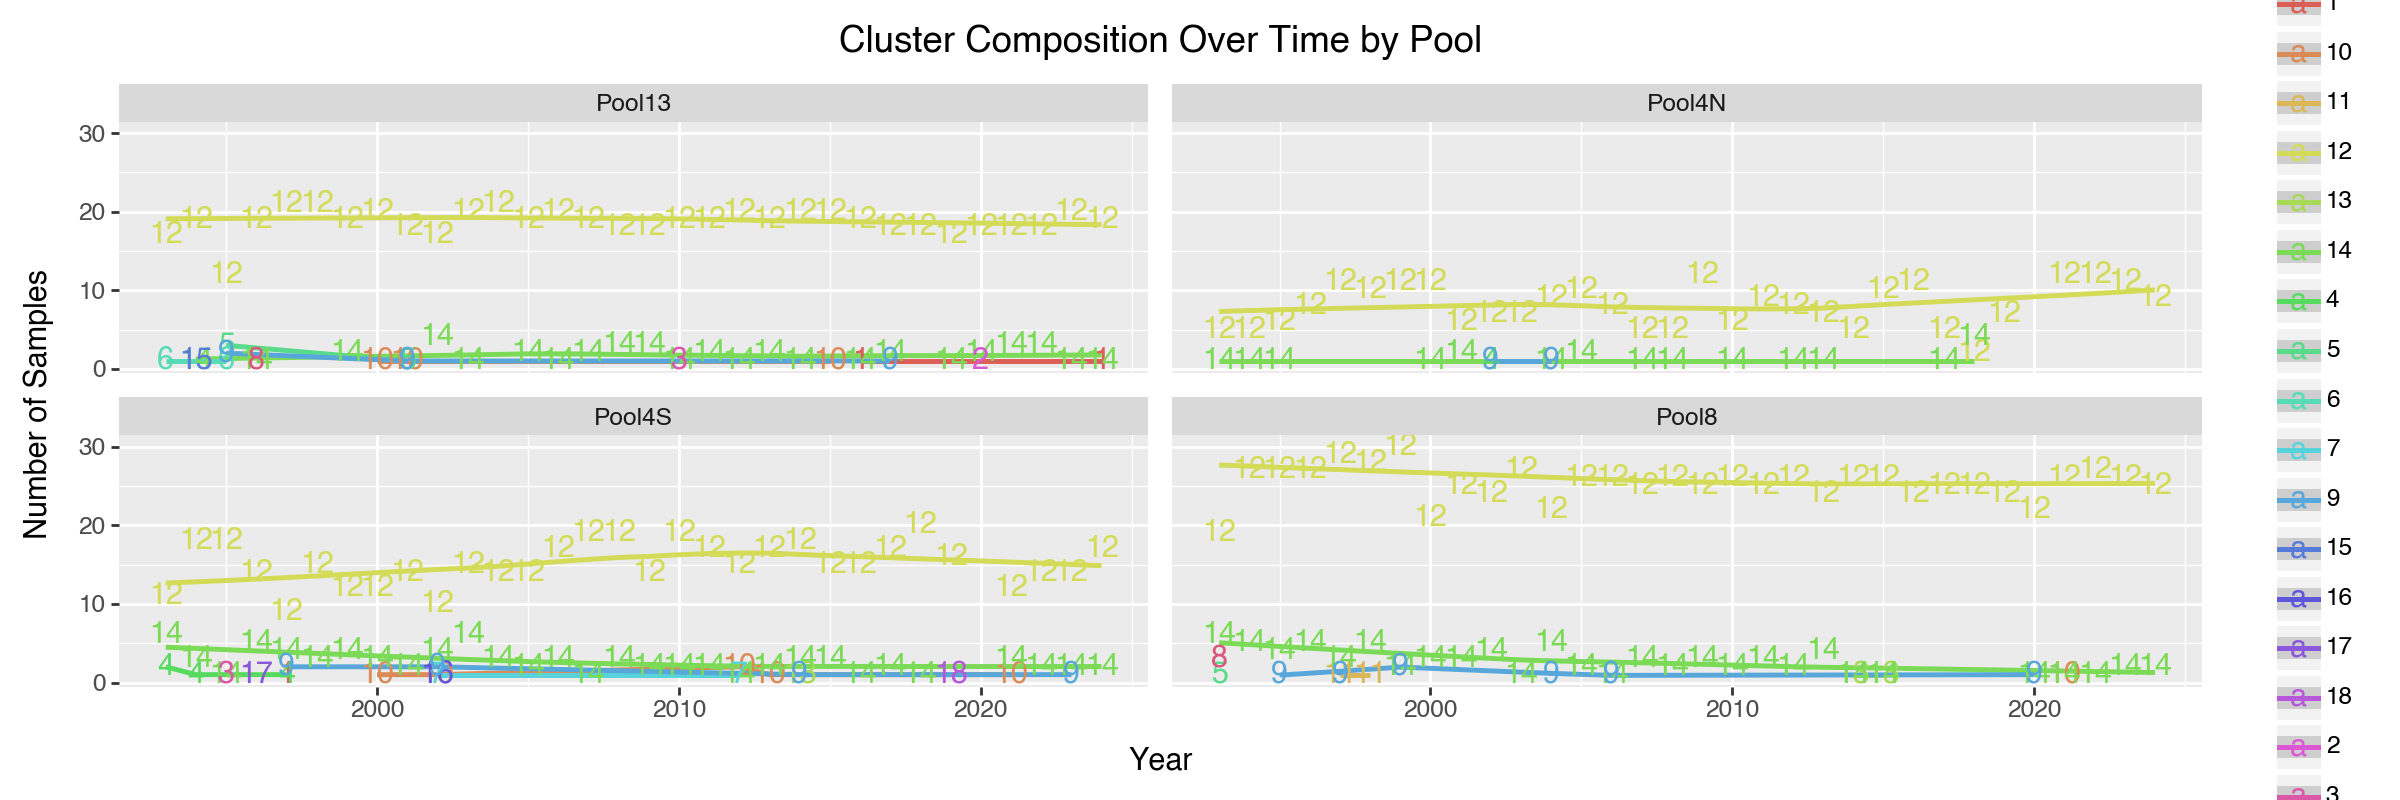

In [36]:
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, scale_y_log10

# Count samples per year per cluster
cluster_time = agg_df.groupby(['year', 'cluster']).size().reset_index(name='count')
cluster_time['cluster'] = cluster_time['cluster'].astype(str)

# Create the plot
(ggplot(cluster_time, aes(x='year', y='count', color='cluster')) +
 geom_line() +
 geom_point() +
 labs(x='Year', y='Number of Samples', color='Cluster', 
    title='Cluster Composition Over Time') +
 scale_y_log10()
 )
from plotnine import *

# Count samples per year per cluster per pool
cluster_time_pool = agg_df.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Create the plot with faceting by pool
(ggplot(cluster_time_pool, aes(x='year', y='count', color='cluster')) +
 geom_line() +
 geom_smooth(method = 'lm') +
 geom_point() +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', 
    title='Cluster Composition Over Time by Pool') 
    #+
 #scale_y_log10()
 )
# Count samples per year per cluster per pool
cluster_time_pool = agg_df.groupby(['year', 'cluster', 'mode_pool']).size().reset_index(name='count')
cluster_time_pool['cluster'] = cluster_time_pool['cluster'].astype(str)

# Create the plot with faceting by pool
(ggplot(cluster_time_pool.query('cluster != "19"'), aes(x='year', y='count', color='cluster')) +
# geom_line() +
 #geom_point() +
 facet_wrap('~mode_pool') +
 labs(x='Year', y='Number of Samples', color='Cluster', 
    title='Cluster Composition Over Time by Pool') +
geom_smooth() +
geom_text(aes(label='cluster')) +
 #scale_y_log10() +
 theme(figure_size=(12, 4))  # width=12, height=4 inches
 )